In [17]:
from abc import ABC, abstractmethod
import numpy as np
from typing import List

# Activation function interface
class ActivationFunction(ABC):
    @abstractmethod
    def output(self, x: np.ndarray) -> np.ndarray:
        pass

    @abstractmethod
    def derivative(self, x: np.ndarray) -> np.ndarray:
        pass

# Sigmoid activation implementation
class Sigmoid(ActivationFunction):
    def output(self, x: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-x))

    def derivative(self, x: np.ndarray) -> np.ndarray:
        return self.output(x) * (1 - self.output(x))

# ReLU activation implementation
class ReLU(ActivationFunction):
    def output(self, x: np.ndarray) -> np.ndarray:
        return np.maximum(0, x)

    def derivative(self, x: np.ndarray) -> np.ndarray:
        return np.where(x > 0, 1, 0)

# Weighted ReLU activation implementation
class WeightedReLU(ActivationFunction):
    def __init__(self, alpha: float = 0.01):
        self.alpha = alpha

    def output(self, x: np.ndarray) -> np.ndarray:
        return np.maximum(self.alpha * x, x)

    def derivative(self, x: np.ndarray) -> np.ndarray:
        return np.where(x > 0, 1, self.alpha)

# Tanh activation implementation
class Tanh(ActivationFunction):
    def output(self, x: np.ndarray) -> np.ndarray:
        return np.tanh(x)

    def derivative(self, x: np.ndarray) -> np.ndarray:
        return 1 - np.tanh(x)**2

# Cost function interface
class CostFunction(ABC):
    @abstractmethod
    def derivative(self, target: np.ndarray, output: np.ndarray) -> np.ndarray:
        pass

# Mean squared cost implementation
class MeanSquared(CostFunction):
    def derivative(self, output: np.ndarray, target: np.ndarray) -> np.ndarray:
        return target - output

# Perceptron class
class Perceptron:
    def __init__(self, input_size: int, activation: ActivationFunction):
        self.weights = np.random.randn(input_size, 1)
        self.bias = np.zeros((1, 1))
        self.activation = activation

    def feedforward(self, X: np.ndarray) -> np.ndarray:
        self.output = self.activation.output(np.dot(X, self.weights) + self.bias)
        return self.output

    def backward(self, X: np.ndarray, error: np.ndarray, learning_rate: float) -> np.ndarray:
        delta = error * self.activation.derivative(self.output)
        self.weights += X.T.dot(delta) * learning_rate
        self.bias += np.sum(delta, axis=0, keepdims=True) * learning_rate
        return np.dot(delta, self.weights.T)

# Layer class
class Layer:
    def __init__(self, input_size: int, num_neurons: int, activation: ActivationFunction):
        self.perceptrons = [Perceptron(input_size, activation) for _ in range(num_neurons)]

    def feedforward(self, X: np.ndarray) -> np.ndarray:
        return np.concatenate([perceptron.feedforward(X) for perceptron in self.perceptrons], axis=1)

    def backward(self, X: np.ndarray, errors: np.ndarray, learning_rate: float) -> np.ndarray:
        delta_accumulated = [perceptron.backward(X, errors[:, i:i+1], learning_rate) for i, perceptron in enumerate(self.perceptrons)]

        return np.concatenate(delta_accumulated, axis=1)

# NeuralNetwork class
class NeuralNetwork:
    def __init__(self, layers: list, cost: CostFunction):
        self.layers = layers
        self.cost = cost

    def train(self, input_data: np.ndarray, target_data: np.ndarray, epochs: int, learning_rate: float) -> None:
        for epoch in range(epochs):
            layer_inputs = [input_data]

            # Forward pass
            for layer in self.layers:
                layer_inputs.append(layer.feedforward(layer_inputs[-1]))

            # Backward pass
            output_error = self.cost.derivative(layer_inputs.pop(), target_data)
            for layer, layer_input in zip(reversed(self.layers), reversed(layer_inputs)):
                output_error = layer.backward(layer_input, output_error, learning_rate)


    def predict(self, input_data: np.ndarray) -> np.ndarray:
        layer_input = input_data
        for layer in self.layers:
            layer_input = layer.feedforward(layer_input)
        return layer_input

# Training monitor class
class TrainingMonitor:
    def __init__(self):
        self.loss_history: List[float] = []

    def log_epoch(self, epoch: int, loss: float) -> None:
        print(f"Epoch {epoch + 1}/{len(self.loss_history)} - Loss: {loss}")

    def monitor_training(self, neural_network, input_data: np.ndarray, target_data: np.ndarray, epochs: int, learning_rate: float) -> None:
        for epoch in range(epochs):
            neural_network.train(input_data, target_data, 1, learning_rate)  # Train for one epoch
            predicted_output = neural_network.predict(input_data)
            loss = np.mean(neural_network.cost.derivative(target_data, predicted_output))
            self.loss_history.append(loss)
            # self.log_epoch(epoch, loss)

        print("Training complete.")

Training complete.


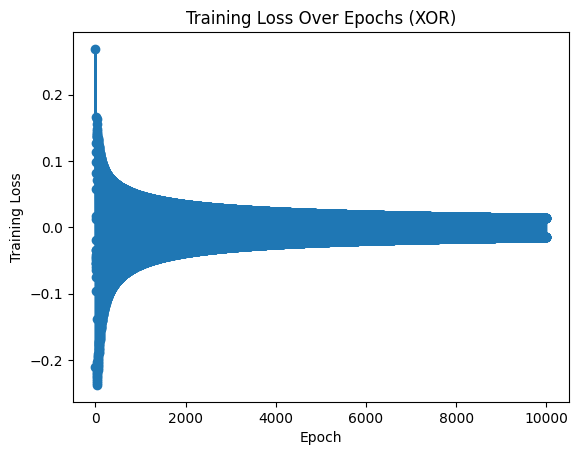

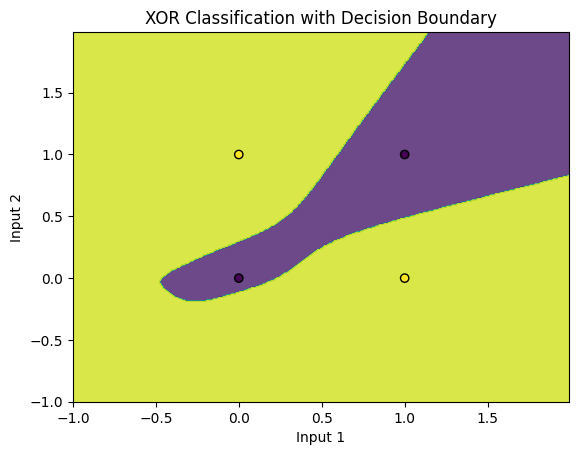

In [18]:
import matplotlib.pyplot as plt

# Training data for XOR
input_data_xor = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
target_data_xor = np.array([[0], [1], [1], [0]])

# Creating and training the neural network for XOR
nn_xor = NeuralNetwork([
    Layer(2, 5, Tanh()),
    Layer(5, 5, Tanh()),
    Layer(5, 1, Tanh()),
], MeanSquared())

# Create a training monitor with loss history for XOR
monitor_xor = TrainingMonitor()

# Train the neural network for XOR with monitoring
monitor_xor.monitor_training(nn_xor, input_data_xor, target_data_xor, epochs=10000, learning_rate=0.1)

# Plot the overall training loss for XOR
plt.plot(range(1, len(monitor_xor.loss_history) + 1), monitor_xor.loss_history, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs (XOR)')
plt.show()

# Create a meshgrid of points for XOR
h_xor = 0.01
x_min_xor, x_max_xor = input_data_xor[:, 0].min() - 1, input_data_xor[:, 0].max() + 1
y_min_xor, y_max_xor = input_data_xor[:, 1].min() - 1, input_data_xor[:, 1].max() + 1
xx_xor, yy_xor = np.meshgrid(np.arange(x_min_xor, x_max_xor, h_xor), np.arange(y_min_xor, y_max_xor, h_xor))
grid_xor = np.c_[xx_xor.ravel(), yy_xor.ravel()]

# Predict the function value for the whole grid for XOR
Z_xor = np.round(nn_xor.predict(grid_xor)).reshape(xx_xor.shape)

# Plot the contour and training examples for XOR
plt.contourf(xx_xor, yy_xor, Z_xor, alpha=0.8)
plt.scatter(input_data_xor[:, 0], input_data_xor[:, 1], c=target_data_xor.ravel(), edgecolors='k')
plt.xlabel('Input 1')
plt.ylabel('Input 2')
plt.title('XOR Classification with Decision Boundary')
plt.show()